#<center> TP 1 - Faits stylisés <center/>
---
---
> But du TP : Visualiser les $\textbf{faits stylisés (régularité statistiques du comportement des marchés)}$, afin d'avoir les outils nécessaires lorsqu'on travaillera avec les modèles d'agents.

In [ ]:
# Import de nos drive pour les fichiers
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import des librairies
!pip install yfinance
!pip install powerlaw
!pip install pyarrow
import powerlaw
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.stats as stats
import seaborn as sns
import powerlaw
from statsmodels.graphics.tsaplots import plot_acf
import pyarrow.parquet as pq
plt.style.use("ggplot")

---
# 2 - Obtenir des données

## 2.1 - Données journalières (yahoo)

- On utilise yahoo finance pour récupérer nos données journalières. Nous allons prendre le maximum d'historique possible. 

- On émet ici la différence entre adjusted et close price. 
  -  Le $\textbf{Closing Price}$ est la valeur de l'action au close de la journée de trading, au prix de la dernière transaction de la journée.

  -  Le $\textbf{Adjusted Close}$ est le closing price ajusté de facteurs tels que les dividendes, stock splits, ou autres évenements. Il permet d'avoir une vision plus précise du "vrai" prix que le closing price.

- Nous considérerons donc le Adjusted Close pour les données journalières.

- Nous considérons les titres $Apple$ et $SPY$ (tracker du S&P500).

In [ ]:
%%capture
# APPLE
apple_d = yf.download("AAPL")
# S&P500
spy_d = yf.download("SPY")

## 2.2 - Données intraday 

- Ici l'index ne sera pas journalier mais de type datetime64[ns] (unité nanoseconds (ns)). Les index de nos DataFrame seront en DatetimeIndex (structure la plus commune pour les time series pandas).


In [ ]:
# Fonction permettant de loader les csv | A changer et mettre 17h pour la fermeture si c'est européen
def load_TRTH_bbo(filename,
             tz_exchange="America/New_York",
             open_time="09:30:00",
             close_time="16:00:00",
             only_regular_trading_hours=True):

    DF = pd.read_csv(filename)
 
    DF.index = pd.to_datetime(DF["xltime"],unit="d",origin="1899-12-30",utc=True)
    DF.index = DF.index.tz_convert(tz_exchange)  # .P stands for Arca, which is based at New York
    DF.drop(columns="xltime",inplace=True)

    if only_regular_trading_hours:
        DF=DF.between_time(open_time,close_time)    # warning: ever heard e.g. about Thanksgivings?

    return DF

In [ ]:
# On load nos dataframes depuis les csv
apple_09 = load_TRTH_bbo("/content/drive/MyDrive/Colab Notebooks Centrale/Physique des marchés/TP 1 - Faits stylisés/2012-02-09-AAPL.OQ-bbo.csv")
apple_10 = load_TRTH_bbo("/content/drive/MyDrive/Colab Notebooks Centrale/Physique des marchés/TP 1 - Faits stylisés/2012-02-10-AAPL.OQ-bbo.csv")
spy_09 = load_TRTH_bbo("/content/drive/MyDrive/Colab Notebooks Centrale/Physique des marchés/TP 1 - Faits stylisés/2012-02-09-SPY.P-bbo.csv")
spy_10 = load_TRTH_bbo("/content/drive/MyDrive/Colab Notebooks Centrale/Physique des marchés/TP 1 - Faits stylisés/2012-02-10-SPY.P-bbo.csv")

---
# 3 - Calcul des rendements

- Nous utiliserons toujours les log-rendements, qui respectent la multiplicativité des rendements, et ont le bénéfice d'être additifs.

## 3.1 - Données journalières

- On note que les log rendements calculés sur le "Close" ou le "Adj Close" nous donne les mêmes rendements.

In [ ]:
# Ajout de des log-rendements
apple_d['log_r'] = np.log(apple_d['Adj Close']).diff()
apple_d.dropna(inplace=True)
spy_d['log_r'] = np.log(spy_d['Adj Close']).diff()
spy_d.dropna(inplace=True)

## 3.2 - Données intraday

- Si jamais, toujours pensez à nettoyer les données de sorte à ne conserver les données de marchés lorsqu'ils sont ouverts : 

  - 9h : 17h30 pour titres européens

  - 9h - 16h pour titres US

- Nous allons ajouter notre colonne de prix $\textbf{midprice = (askprice+bidprice)/2}$

- Les rendements se calculent sur le midprice. Il ne faut pas oublier d'enelever les rendements $NaN$.

- Nous prenons des rendements à $5min$ car la plupart du temps les rendements du MidPrice sont à $0$, ce qui nous empeche de voir quelque chose d'intéressant (trop discret). On va donc utiliser $\textit{.resample()}$ afin de pointer nos rendements sur $5min$.

In [ ]:
def intraday_mid_log_r(asset, resample="5min", ohlc=False):
  """ Fonction calculant le log rendement du mid-price pour données intraday"""
  newasset = asset
  # On calcule le midprice pour chaque
  newasset["mid-price"] = (newasset["bid-price"] + newasset["ask-price"])/2
  # On reshape nos données
  if ohlc:
    # On split en open, high, low, close
    newasset = asset.resample(resample).ohlc()
    # On calcule nos rendements à partir du close
    newasset["log_r"] = np.log(newasset["mid-price"]["close"]).diff()
  else:
    # On pointe à 5min
    newasset = asset.resample(resample).first()
    # On calcule nos rendements
    newasset["log_r"] = np.log(newasset["mid-price"]).diff()
  return newasset.dropna()

In [ ]:
apple_09_5m = intraday_mid_log_r(apple_09)
apple_10_5m = intraday_mid_log_r(apple_10)
spy_09_5m = intraday_mid_log_r(spy_09)
spy_10_5m = intraday_mid_log_r(spy_10)

# Pour vérifier qu'on a aucun NaN
# apple_09_5m.isna().values.any()  

# On affiche les 5 premieres lignes pour vérification
apple_09_5m.head()

,bid-price,bid-volume,ask-price,ask-volume,mid-price,log_r
xltime,,,,,,
2012-02-09 09:35:00-05:00,482.80,3,482.85,1,482.825,0.004296
2012-02-09 09:40:00-05:00,482.22,2,482.29,2,482.255,-0.001181
2012-02-09 09:45:00-05:00,484.22,1,484.34,1,484.280,0.004190
2012-02-09 09:50:00-05:00,483.71,1,483.79,1,483.750,-0.001095
2012-02-09 09:55:00-05:00,483.69,2,483.84,1,483.765,0.000031


---
# 4 - Analyse empririque

## 4.1 - Rendements : distribution

### 4.1.1 - QQ-plot

In [ ]:
# Fonction qq-plot
def qqplot(asset, i):
  stats.probplot(asset.log_r, dist="norm", plot=ax[i])
  ax[i].set_title(f"{names[i]}")

#### Données journalières

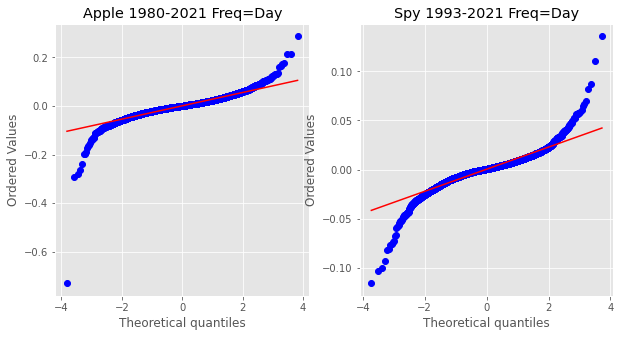

In [ ]:
# Noms pour titres des graphes
names = ["Apple 1980-2021 Freq=Day", "Spy 1993-2021 Freq=Day"]

fig, ax = plt.subplots(1,2,figsize=(10,5))
for i, asset in enumerate([apple_d,spy_d]):
  qqplot(asset, i)

- Nous voyons donc que les rendements ne sont pas du tout gaussiens, les queues étant bien plus grasses que dans le cas d'une loi normale.

#### Données Intraday


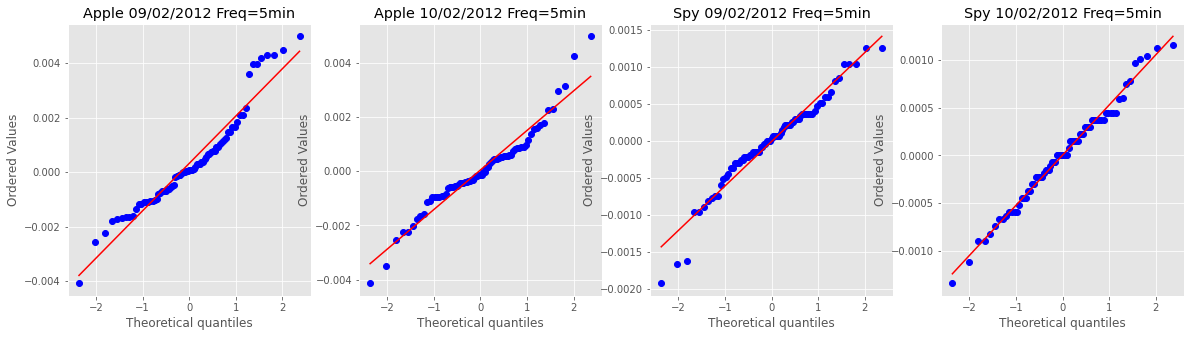

In [ ]:
# Noms pour titres des graphes
names = ["Apple 09/02/2012 Freq=5min", "Apple 10/02/2012 Freq=5min", "Spy 09/02/2012 Freq=5min", "Spy 10/02/2012 Freq=5min"]

fig, ax = plt.subplots(1,4,figsize=(20,5))
for i, asset in enumerate([apple_09_5m, apple_10_5m, spy_09_5m, spy_10_5m]):
  qqplot(asset, i)

- Nous pouvons voir que pour les données intraday $Apple$ du 09/02 et 10/02 que les queues de distributions sont plus lourdes que celles d'une gaussienne. Même si c'est moins prononcé que dans le cas de rendements journaliers.

- Nous remarquons la même chose pour le $SPY$, mais pour le 10/02, les rendments s'alignent bien plus avec les quantiles théoriques.


### 4.1.2 - Ccdf

- Nous allons vérifier si la distribution de la valeur absolue des rendements a une queue lourde pour nos datasets. Pour cela, nous allons tracer la ccdf en linéaire-log et log-log, accompagné du cas gaussien pour comparaison. De plus, nous pourrons réutiliser la fonction lorsque nous travaillerons sur les modèles d'agents.
  - On utilise la distribution cumulatrice car cela nous permet d'avoir les points aux probabilités très faibles (avec un histogramme nous ne verrions pas grand chose).

- Pour le cas linéaire-log, si nous distinguons une convexité, cela est la preuve visuelle d'une queue queue grasse.
- Pour le cas log-log, si nous voyons approximativement une droite, cela permet de dire qu'on a un comportement en loi de puissance. 

- Important : 
  - On suppose dans cette partie que $P(r) = P(-r)$, nous allons donc seulement calculer la probabilité cummulatrice $P_{>}(|r|) = P(|return| > |r|)$. De plus prendre $|r|$ permet d'avoir tous les moments qui sont définis.
  - La fonction empirique de distribution classique considère $P(X \leq x)$, nous allons donc utiliser $1-ecdf(|r|)$.

In [ ]:
# Fonction pour fonction cumulatrice 1 - ecdf()
def P_cumsup_r(asset, i, xscale="log", plot_gaussian=False, fix_seed=True):
  if xscale != "log" and xscale != "linear":
    raise TypeError("xscale doit être en log ou linéaire")
  if plot_gaussian:                                         
    if fix_seed: np.random.seed(77)                           # moyenne des returns  # ecart-type des returns
    lograndom_g = np.unique(np.sort(np.abs(np.random.normal(loc=asset.log_r.mean(),scale=asset.log_r.std(),size=asset.log_r.shape[0])))) # On rescale sur 100 pour coller avec les rendements
    Ecdf_g = ECDF(lograndom_g)

  # On trie les valeurs absolues distinctes des rendements
  r_abs = np.unique(np.sort(np.abs(asset.log_r)))
  y = ECDF(r_abs) # On peut noter que la fonction ECDF trie directement les valeurs

  # On plot le graphique
  ax[i].set(title=r"$P_{>}(|r|)$ for %s" %(names[i]), xlabel=f"$|r|$ - scale {xscale}", ylabel="$P_{>}(|r|)$", xscale=xscale, yscale="log")
  # On utilise step pour les fonctions en escalier
  ax[i].step(r_abs, 1 - y(r_abs), label="Return", color="red")
  if plot_gaussian: ax[i].step(lograndom_g, 1 - Ecdf_g(lograndom_g), label="Gaussian", linestyle="--", color="black")
  ax[i].legend()

#### Données Journalières

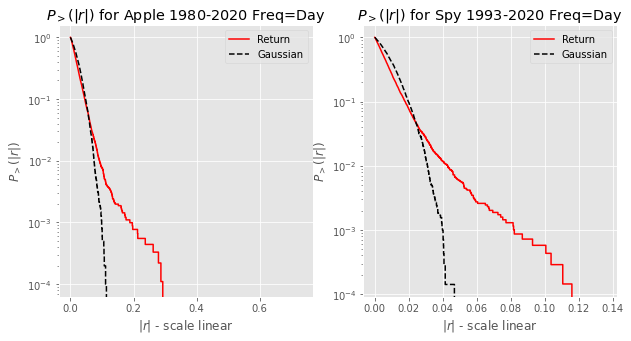

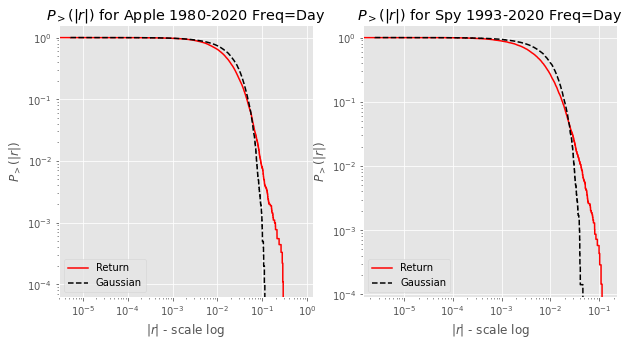

In [ ]:
# Noms pour titres des graphes
names = ["Apple 1980-2020 Freq=Day", "Spy 1993-2020 Freq=Day"]

# Scale linear
fig, ax = plt.subplots(1,2,figsize=(10,5))
for i, asset in enumerate([apple_d,spy_d]):
  P_sup_r(asset, i, xscale="linear", plot_gaussian=True)

# Scale log
fig, ax = plt.subplots(1,2,figsize=(10,5))
for i, asset in enumerate([apple_d,spy_d]):
  P_sup_r(asset, i, xscale="log", plot_gaussian=True)

- Nous retrouvons le cas du cours, la concavité pour les deux premiers graphes de scale linéaire-log pour les rendements nous prouvent que les queues décroissent plus lentement que toute exponentielle. Nous avons donc bien des queues grasses. 

- On le vérifie également le comportement de loi de puissance en tracant le cas log-log.

#### Données intraday

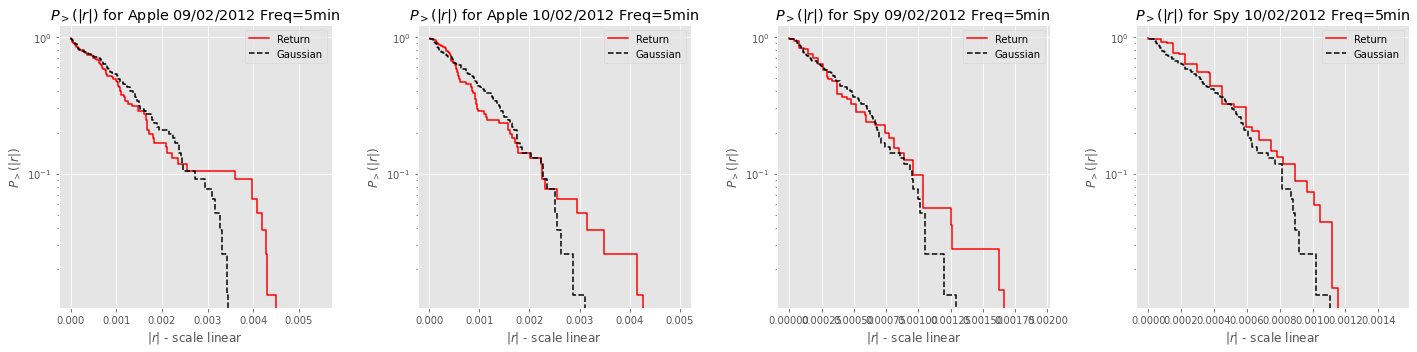

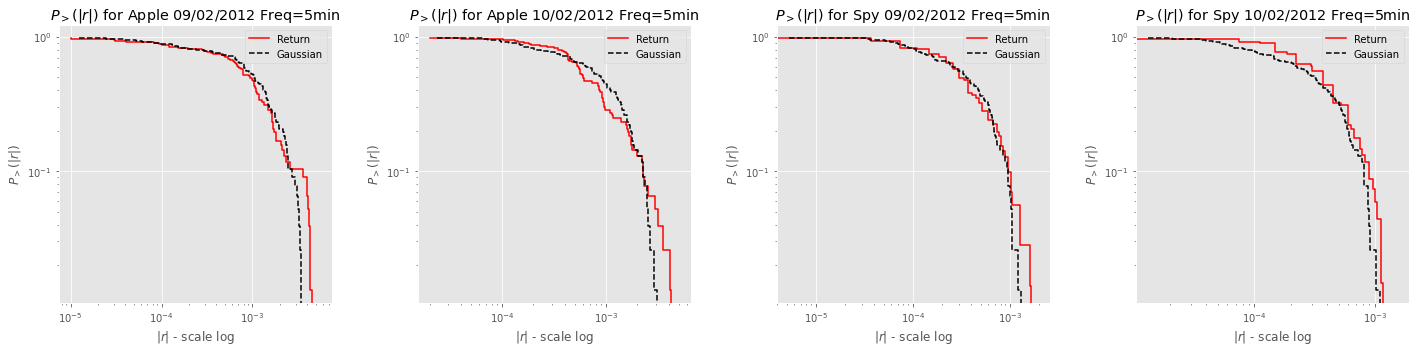

In [ ]:
# Noms pour titres des graphes
names = ["Apple 09/02/2012 Freq=5min", "Apple 10/02/2012 Freq=5min", "Spy 09/02/2012 Freq=5min", "Spy 10/02/2012 Freq=5min"]

# Scale linear
fig, ax = plt.subplots(1,4,figsize=(20,5))
for i, asset in enumerate([apple_09_5m, apple_10_5m, spy_09_5m, spy_10_5m]):
  P_sup_r(asset, i, xscale="linear", plot_gaussian=True)
plt.tight_layout()

# Scale log
fig, ax = plt.subplots(1,4,figsize=(20,5))
for i, asset in enumerate([apple_09_5m, apple_10_5m, spy_09_5m, spy_10_5m]):
  P_sup_r(asset, i, xscale="log", plot_gaussian=True)
plt.tight_layout()

- De même, nous pouvons voir que les queues sont grasses du à la concavité dans le cas du xscale linéaire. 

- Notons tout de même que, comme pour le qq-plot précédent, la concavité du return $S\&P500$ est bien moins remarquable, de même pour le scale log-log qui est clairement moins parlant.

### 4.1.3 - Détermination du coefficient de la queue de distribution - powerlaw


#### Données Journalières

In [ ]:
%%capture
apple_d_pw = powerlaw.Fit(np.unique(np.sort(np.abs(apple_d.log_r)))).alpha # .alpha pour avoir directement l'exposant
spy_d_pw = powerlaw.Fit(np.unique(np.sort(np.abs(spy_d.log_r)))).alpha

In [ ]:
print(f"Explosant de la queue de distribution pour APPLE : {apple_d_pw}")
print(f"Explosant de la queue de distribution pour SPY : {spy_d_pw}")

Explosant de la queue de distribution pour APPLE : 4.375547302873173
Explosant de la queue de distribution pour SPY : 3.6316283033605083


- Pour les données journalières, on voit que les exposants sont tout de même supérieurs à $3$ en valeurs absolues. Mais cela est cohérent, en effet les rendements de titres financiers ont un exposant aux alentours de $3$.
- Quand nous calculons l'exposant d'échantillons gaussiens pour moyenne et st associée aux assets, on a $\sim 9$ pour $Apple$ et $SPY$, ce qui est cohérent avec le fait que la courbe gaussienne associée en log-log est bien plus pentue et "tombe" plus rapidement.

#### Données Intraday

In [ ]:
%%capture
apple_09_5m_pw = powerlaw.Fit(np.unique(np.sort(np.abs(apple_09_5m.log_r)))).alpha
apple_10_5m_pw = powerlaw.Fit(np.unique(np.sort(np.abs(apple_10_5m.log_r)))).alpha
spy_09_5m_pw = powerlaw.Fit(np.unique(np.sort(np.abs(spy_09_5m.log_r)))).alpha
spy_10_5m_pw = powerlaw.Fit(np.unique(np.sort(np.abs(spy_10_5m.log_r)))).alpha

In [ ]:
print(f"Explosant de la queue de distribution pour APPLE 09/02 : {apple_09_5m_pw}")
print(f"Explosant de la queue de distribution pour APPLE 10/02 : {apple_10_5m_pw}")
print(f"Explosant de la queue de distribution pour SPY 09/02 : {spy_09_5m_pw}")
print(f"Explosant de la queue de distribution pour SPY 10/02 : {spy_10_5m_pw}")

Explosant de la queue de distribution pour APPLE 09/02 : 2.6245692385965347
Explosant de la queue de distribution pour APPLE 10/02 : 1.9410294709224827
Explosant de la queue de distribution pour SPY 09/02 : 4.242979288923008
Explosant de la queue de distribution pour SPY 10/02 : 4.097111423637369


- Nous voyons ici que pour le $S\&P500$, l'exposant est légèrement supérieur à $4$ pour les deux jours. 

- En revanche, pour $Apple$, et surtout pour le deuxième jour, l'exposant est plus faible.

---
## 4.2 - Autocorrelation

 

### 4.2.1 - Données Journalières

- Dans ce cas nous allons tracer la courbe d'autocorrélation de la valeur absolue des rendements, avec des axes log-log, et un temps de lag maximal suffisement grand pour les rendements journalier (par ex 256 dans le sujet). 

[None,
 (0.01, 1),
 Text(0, 0.5, 'autocorrelation'),
 None,
 Text(0.5, 0, 'lag'),
 Text(0.5, 1.0, 'Autocorrélation des log-rendements Spy')]

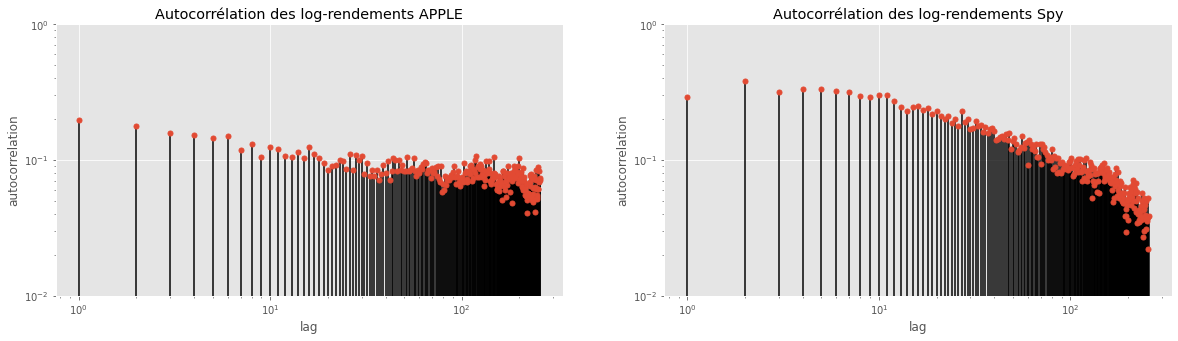

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

# Acf pour Apple
plot_acf(apple_d.log_r.abs(),lags=256, alpha=None, ax=ax[0]);
ax[0].set(title="Autocorrélation des log-rendements APPLE", xlabel="lag", ylabel="autocorrelation", xscale="log", yscale="log", ylim=(10**-2,1))
# Acf pour Spy
plot_acf(spy_d.log_r.abs(),lags=256, alpha=None, ax=ax[1]);
ax[1].set(title="Autocorrélation des log-rendements Spy", xlabel="lag", ylabel="autocorrelation", xscale="log", yscale="log", ylim=(10**-2,1))

- Nous pouvons donc distinguer des droites pour la décroissance de l'autocorrélation sur les deux graphiques, cela fait donc penser à une loi de puissance. 
  - La décroissance est ainsi très lente, et nous retrouvons donc bien ici les effets de "volatility clustering".
  - De plus on peut voir que la décroissance pour AAPLE est très plate, ce qui pourrait signifier que l'exposant de la loi de puissance est petit.

- En fait, la volatilité est fortement autocorrélée, a des queues grasses et n'a pas d'échelle de temps caractéristiques. On pense que c'est une loi de puissance qui contient la superposition de toutes les échelles de temps possibles.

### 4.2.2 - Données Intraday

- Dans ce cas nous allons tracer l'autocorrélation des rendements  à l'échelle seconde. Nous allons donc resampler nos données et en tracer les fonctions d'autocorrélations. 

In [ ]:
# On resample pour avoir un pointage en secondes
apple_09_s = intraday_mid_log_r(apple_09, resample="s")
apple_10_s = intraday_mid_log_r(apple_10, resample="s")
spy_09_s = intraday_mid_log_r(spy_09, resample="s")
spy_10_s = intraday_mid_log_r(spy_10, resample="s")

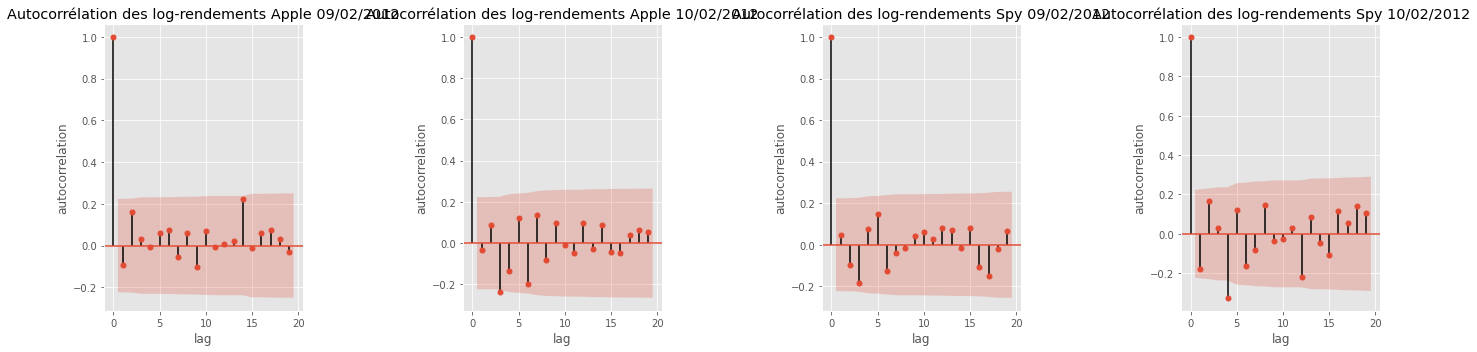

In [ ]:
names = ["Apple 09/02/2012", "Apple 10/02/2012", "Spy 09/02/2012", "Spy 10/02/2012"]
fig, ax = plt.subplots(1,4,figsize=(20,5))
for i, asset in enumerate([apple_09_5m, apple_10_5m, spy_09_5m, spy_10_5m]):
  plot_acf(asset.log_r, ax=ax[i]);
  ax[i].set(title=f"Autocorrélation des log-rendements {names[i]}", xlabel="lag", ylabel="autocorrelation")
plt.tight_layout()

- Nous voyons donc que les rendements ne sont pas corrélés, d'après les intervalles de confiance issus du test de Bartlett.
  - Nous vérifions donc que l'autocorrélation des rendements (sans valeur absolue) est nulle.

- En fait, les rendements eux-mêmes sont très aléatoires, mais la volatilité elle n'est pas aléatoire (c'est pour cela qu'on utilise en général des modèles de volatilité).

---
# 4.3 - Mesures de volatilité



## 4.3.1 - Variation Quadratique

- Le fait d'utiliser la variations quadratique en tant qu'estimateur de volatilité est assez naïf, par exemple :
  - si le prix revient à sa moyenne pour des intervalles de temps consécutifs et que nous prenons nos rendements à ce moment-là, alors nous pourions rater une forte volatilité sur chaque intervalle de temps : on raterait la volatilité intrinsèque au processus.
  - Utiliser la variation quadratique serait efficace si la volatilité était constante, sans mémoire, etc...

- Nous allons calculer la variation quadratique pour nos datasets afin de la comparer avec un autres estimateur de la volatilité.

- Note : Le paramètre $A$ sert à se ramener à une échelle de temps comparable car dans le cas intraday et journalier nous n'avons absolument pas le même nombre de points.

In [ ]:
def var_quadratique(asset, freq="daily"):
  if freq=="daily":
    A = 252 # Nb de trading days aux US
  elif freq=="min":
    A = 60*7*252 # 60min*7h (7h car les marchés sont ouverts 7h aux US)
  return A*np.mean(asset.log_r**2)

### Données journalières

In [ ]:
print(f"Variations quadratique pour les rendements journaliers AAPLE : {var_quadratique(apple_d)}")
print(f"Variations quadratique pour les rendements journaliers SPY : {var_quadratique(spy_d)}")

Variations quadratique pour les rendements journaliers AAPLE : 0.2131004530879179
Variations quadratique pour les rendements journaliers SPY : 0.035717660542884264


### Données intradaday

In [ ]:
# On reprend nos données en 5 minutes avec le format ohlc()
apple_09_5m_ohlc = intraday_mid_log_r(apple_09, ohlc=True)
apple_10_5m_ohlc = intraday_mid_log_r(apple_10, ohlc=True)
spy_09_5m_ohlc = intraday_mid_log_r(spy_09, ohlc=True)
spy_10_5m_ohlc = intraday_mid_log_r(spy_10, ohlc=True)

In [ ]:
print(f"Variations quadratique pour les rendements journaliers AAPLE 09/02 : {var_quadratique(apple_09_5m_ohlc, freq='min')}")
print(f"Variations quadratique pour les rendements journaliers AAPLE 10/02 : {var_quadratique(apple_10_5m_ohlc, freq='min')}")
print(f"Variations quadratique pour les rendements journaliers SPY 09/02 : {var_quadratique(spy_09_5m_ohlc, freq='min')}")
print(f"Variations quadratique pour les rendements journaliers SPY 10/02 : {var_quadratique(spy_10_5m_ohlc, freq='min')}")

Variations quadratique pour les rendements journaliers AAPLE 09/02 : 0.3088815671077878
Variations quadratique pour les rendements journaliers AAPLE 10/02 : 0.22033965257904192
Variations quadratique pour les rendements journaliers SPY 09/02 : 0.0380257996291877
Variations quadratique pour les rendements journaliers SPY 10/02 : 0.03028453224211094


- Nous voyons la cohérence des variations quadratiques entre les jeux de donnnées intraday et journaliers pour $Apple$ et $SPY$, du même ordre de grandeur dans les deux cas.

## 4.3.2 - Estimateur de Garman Klass

- Cet estimateur se base sur l'excursion entre les points, en fait, il prend également en compte les minimums et maximums de chaque intervalle de temps, ce qui permet d'avoir plus d'informations.

- Note : Ici on prend le close et non pas le Adjusted close dans le cas journalier car au début de notre série temporelle le adjusted close est $ < 1$, ce qui serait donc négatif en passant au log.

In [ ]:
def garman_klass(asset, freq="daily"):
  if freq=="daily":
    A = 252 # Nb de trading days aux US
    high = asset["High"]
    low = asset["Low"]
    close = asset["Close"] # Ne marche pas avec le Adj Closes
    open = asset["Open"]

  elif freq=="min":
    A = 60*7*252 # 60min*7h (7h car les marchés sont ouverts 7h aux US)
    high = asset["mid-price"]["high"]
    low = asset["mid-price"]["low"]
    close = asset["mid-price"]["close"]
    open = asset["mid-price"]["open"]

  return A * np.mean(0.5*np.log(high/low)**2 - (2*np.log(2) - 1)*np.log(close/open)**2)

### Données journalières

In [ ]:
print(f"Garman Klass pour les rendements journaliers AAPLE : {garman_klass(apple_d)}")
print(f"Garman Klass pour les rendements journaliers SPY : {garman_klass(spy_d)}")

Garman Klass pour les rendements journaliers AAPLE : 0.13347140233163438
Garman Klass pour les rendements journaliers SPY : 0.025265861563830472


### Données intraday


In [ ]:
print(f"Garman Klass pour les rendements journaliers AAPLE 09/02 : {garman_klass(apple_09_5m_ohlc, freq='min')}")
print(f"Garman Klass pour les rendements journaliers AAPLE 10/02 : {garman_klass(apple_10_5m_ohlc, freq='min')}")
print(f"Garman Klass pour les rendements journaliers SPY 09/02 : {garman_klass(spy_09_5m_ohlc, freq='min')}")
print(f"Garman Klass pour les rendements journaliers SPY 10/02 : {garman_klass(spy_10_5m_ohlc, freq='min')}")

Garman Klass pour les rendements journaliers AAPLE 09/02 : 0.2243209153138251
Garman Klass pour les rendements journaliers AAPLE 10/02 : 0.18713024978505696
Garman Klass pour les rendements journaliers SPY 09/02 : 0.0379851402927326
Garman Klass pour les rendements journaliers SPY 10/02 : 0.031370466313815695


## 4.3.3 - Comparaison 

- On remarque l'estimateur de Garman Klass donne une volatilité réduite comparé à la variation quadratique pour $Apple$.

- Cepedant, dans le cas des rendements intraday, on voit que la réduction est moindre. Donc, plus la variation quadratique est faible et moins l'estimateur de garman klass renverra une valeur réduite.

---
# 4.4 - Estimation du nombre de sauts

- Dans cette partie, nous allons télécharger le fichier au format parquet fourni, afin de réaliser des estimations des nombres de sauts en fonction de certains seuils, et analyser ce qu'on obtient.

In [ ]:
%%capture
# On télécharge les données
es_mini_spfut = pq.read_table("/content/drive/MyDrive/Colab Notebooks Centrale/Physique des marchés/TP 1 - Faits stylisés/ES-bbo_backmonth+0_1minute.parquet").to_pandas()
# On met l'index correspondant à la date
es_mini_spfut.set_index("index", inplace=True)
# On calcule le mid
es_mini_spfut["mid"] = (es_mini_spfut["bid"] + es_mini_spfut["ask"])/2
# On calcule les log rendements et leur valeur absolue
es_mini_spfut["logret"] = np.log(es_mini_spfut["mid"]).diff()
es_mini_spfut["|logret|"] = es_mini_spfut.logret.abs()
# on enleve les NaN (premiere ligne)
es_mini_spfut.dropna(inplace=True)

## 4.4.1 - Moyenne mobile à $30min$

In [ ]:
# On rajoute la MB à 30min et on 
es_mini_spfut["MB30m"] = es_mini_spfut["|logret|"].rolling(30).mean()
es_mini_spfut.head()

,bid,bidQ,ask,askQ,mid,logret,|logret|,MB30m
index,,,,,,,,
1997-09-09 15:32:00+00:00,932.25,10.0,947.75,10.0,940.000,0.003330,0.003330,NaN
1997-09-09 15:33:00+00:00,932.50,10.0,947.75,10.0,940.125,0.000133,0.000133,NaN
1997-09-09 15:34:00+00:00,941.75,2.0,946.50,1.0,944.125,0.004246,0.004246,NaN
1997-09-09 15:35:00+00:00,941.50,8.0,946.25,2.0,943.875,-0.000265,0.000265,NaN
1997-09-09 15:36:00+00:00,942.50,10.0,946.25,2.0,944.375,0.000530,0.000530,NaN


## 4.4.2 - Comparer la moyenne mobile avec le $|r|$ suivant

- Après avoir shifté notre moyenne mobile (nous comparons avec la valeur courante de $|r|$), nous créons une colonne pour chaque seuil $s$ différent, composée de booléen afin de savoir si le $|r|$ actuel a dépassé $s \cdot MB_{30min}$.

In [ ]:
# On shift et on remove les NaN (premiere ligne)
es_mini_spfut["MB30m"] = es_mini_spfut["MB30m"].shift(1)
es_mini_spfut.dropna(inplace=True)

In [ ]:
# On créé nos colonnes
thresolds = np.arange(1,21)
for s in thresolds:
  es_mini_spfut[f"s_{s}"] = es_mini_spfut["|logret|"] > s*es_mini_spfut["MB30m"]

In [ ]:
# On stock notre phi_s correspondant a la fraction de rendement absolu supérieurs aux seuils s
phi_s = [es_mini_spfut[f"s_{s}"].value_counts(normalize=True)[1] for s in thresolds]

## 4.4.3 - Tracer $\phi(s)$ en fonction de $s$

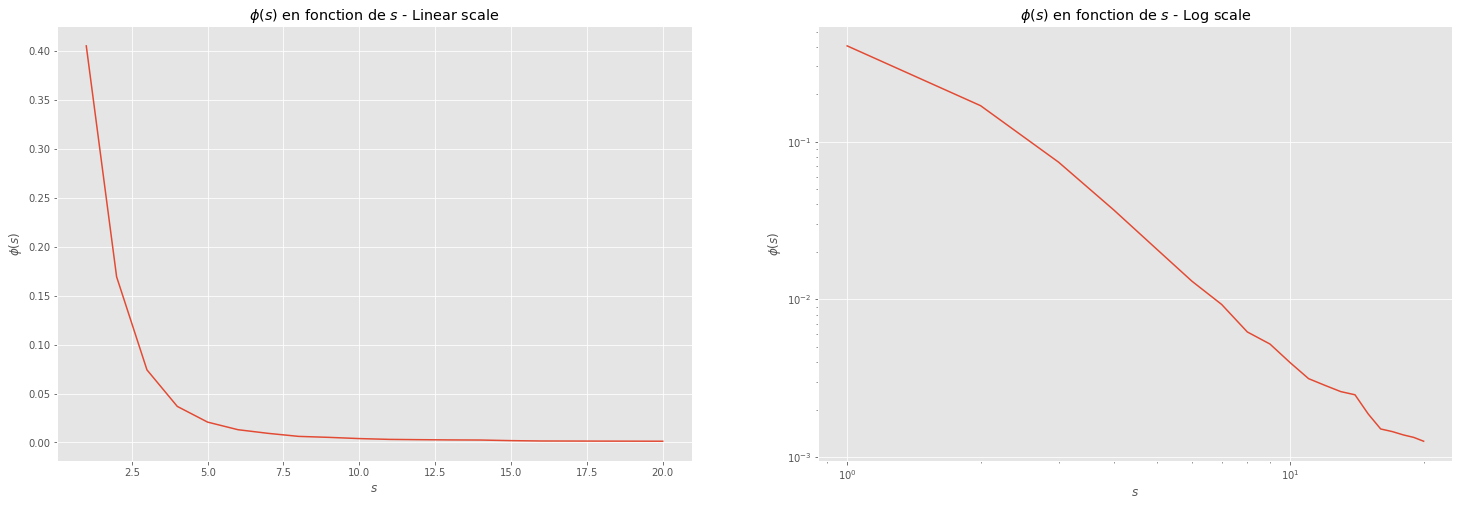

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(25,8))
ax[0].set(title="$\phi(s)$ en fonction de $s$ - Linear scale", xlabel="$s$", ylabel="$\phi(s)$")
ax[0].plot(thresolds, phi_s, label="rr")
ax[1].set(title="$\phi(s)$ en fonction de $s$ - Log scale", xlabel="$s$", ylabel="$\phi(s)$")
ax[1].loglog(thresolds, phi_s);

In [ ]:
%%capture
exposant = powerlaw.Fit(np.sort(phi_s)).alpha

In [ ]:
exposant

1.5678800113890907

- Nous voyons sur les graphe précédents directement que nous avons à faire à une loi de puissance, caractéristique de l'invariance d'échelle.

- Nous savons que le nombre de sauts supérieurs à un certain seuil est censé decroître comme une loi de puissance. (semblable à la loi d'Omori, trouvée à la base pour les tremblements de terre)

- Les modèles d'agents quant à eux, doivent reproduire les faits stylisés vus lors de ce TP. 